In [45]:
import pandas as pd
import numpy as np
from fredapi import Fred
import sklearn
import matplotlib.pyplot as plt

In [ ]:
SELECT FRED FROM ROLLING_CLOUD.PUBLIC.API_KEYS

In [ ]:
df_key  = PULL_KEY.to_df()
fred = Fred(api_key=df_key.first()["FRED"])

In [188]:
start_date = "2014-05-01"
start_date_plus_1_year = "2015-05-01"
end_date = "2025-05-01"

FRBATLWGT12MMUMHWGA1644Y = (
    fred.get_series("FRBATLWGT12MMUMHWGA1644Y", observation_start=start_date)
        .rename("Wage Growth Ages 16-24")             
        .reset_index()                
        .rename(columns={"index": "Date"})   
)

CUUR0000SEHA = (
    fred.get_series("CUUR0000SEHA", observation_start=start_date)
        .rename("CPI Rent")             
        .reset_index()                
        .rename(columns={"index": "Date"})
)

CUUR0000SEFV = (
    fred.get_series("CUUR0000SEFV", observation_start=start_date)
        .rename("CPI Food Away From Home")             
        .reset_index()                
        .rename(columns={"index": "Date"})
)

LNS14000036 = (
    fred.get_series("LNS14000036", observation_start=start_date)
        .rename("Unemployment Rate Ages 20-24")             
        .reset_index()                
        .rename(columns={"index": "Date"})
)

LNS14000089 = (
    fred.get_series("LNS14000089", observation_start=start_date)
        .rename("Unemployment Rate Ages 25-34")             
        .reset_index()                
        .rename(columns={"index": "Date"})
)

CGBD2534 = (
    fred.get_series("CGBD2534", observation_start=start_date)
        .rename("Unemployment Rate Ages 25-34 College Grads")             
        .reset_index()                
        .rename(columns={"index": "Date"})
)

JTS1000JOL = (
    fred.get_series("JTS1000JOL", observation_start=start_date)
        .rename("Job Openings Private")             
        .reset_index()                
        .rename(columns={"index": "Date"})   
)

USPRIV = (
    fred.get_series("USPRIV", observation_start=start_date)
        .rename("Total Employees Private")             
        .reset_index()                
        .rename(columns={"index": "Date"})
)

AWHAETP = (
    fred.get_series("AWHAETP", observation_start=start_date)
        .rename("Weekly Hours Worked Private")             
        .reset_index()                
        .rename(columns={"index": "Date"})
)

from functools import reduce

# List of all your dataframes
dfs = [FRBATLWGT12MMUMHWGA1644Y, CUUR0000SEHA, CUUR0000SEFV, LNS14000036, JTS1000JOL, USPRIV, AWHAETP, LNS14000089, CGBD2534]

# Merge all on 'Date' using outer join
df = reduce(lambda left, right: pd.merge(left, right, on="Date", how="outer"), dfs).sort_values("Date")
df = df[df['Date'] <= end_date]

In [ ]:
df.head()

In [225]:
df_transformed = pd.DataFrame()
df_transformed['Date'] = df['Date']
df_transformed['Wage Growth Ages 16-24'] = df['Wage Growth Ages 16-24']
df_transformed['Rent Inflation'] = df['CPI Rent'].pct_change(periods=12) * 100
df_transformed['Food Away From Home Inflation'] = df['CPI Food Away From Home'].pct_change(periods=12) * 100
df_transformed['Unemployment Rate Ages 20-24'] = df['Unemployment Rate Ages 20-24'] * -1
df_transformed['Bach. Degree Unemployment Differential'] = df['Unemployment Rate Ages 25-34'] - df['Unemployment Rate Ages 25-34 College Grads']
df_transformed['Job Openings Growth Private'] = df['Job Openings Private'].pct_change(periods=12) * 100
df_transformed['Total Employment Growth Private'] = df['Total Employees Private'].pct_change(periods=12) * 100
df_transformed['Weekly Hours Worked Private'] = df['Weekly Hours Worked Private'] * -1
df_transformed['Real Wage Growth Over Rent Inflation'] = df_transformed['Wage Growth Ages 16-24'] - df_transformed['Rent Inflation']
df_transformed['Real Wage Growth Over Food Away From Home Inflation'] = df_transformed['Wage Growth Ages 16-24'] - df_transformed['Food Away From Home Inflation']

df_transformed = df_transformed[df_transformed["Date"] >= start_date_plus_1_year]

In [226]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_values = scaler.fit_transform(df_transformed.drop(columns="Date"))
df_scaled = pd.DataFrame(scaled_values, columns=df_transformed.columns.drop("Date"))
df_scaled["Date"] = df_transformed["Date"]

In [238]:
df_scaled['Index'] = df_scaled['Unemployment Rate Ages 20-24'] + df_scaled['Bach. Degree Unemployment Differential'] + df_scaled['Job Openings Growth Private'] + df_scaled['Weekly Hours Worked Private'] + df_scaled['Real Wage Growth Over Rent Inflation'] + df_scaled['Real Wage Growth Over Food Away From Home Inflation']
min_index = df_scaled['Index'].min() - 0.5
max_index = df_scaled['Index'].max() + 0.5
df_scaled['Index Scaled'] = 100 * (df_scaled['Index'] - min_index) / (max_index - min_index)
df_scaled['MA12'] = df_scaled['Index Scaled'].rolling(window=12).mean()

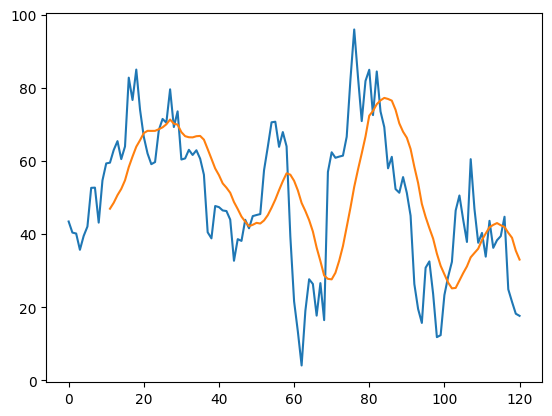

In [239]:
plt.plot(
        #df_scaled["Date"], 
        df_scaled['Index Scaled'],
        #df_scaled['MA12'],
        #df_scaled["Bach. Degree Unemployment Differential"],  
        #df_scaled["Job Openings Growth Private"], 
        #df_scaled['Weekly Hours Worked Private'],
        #df_scaled['Real Wage Growth Over Rent Inflation'],
        #df_scaled['Real Wage Growth Over Food Away From Home Inflation']
        )
plt.plot(df_scaled['MA12'])

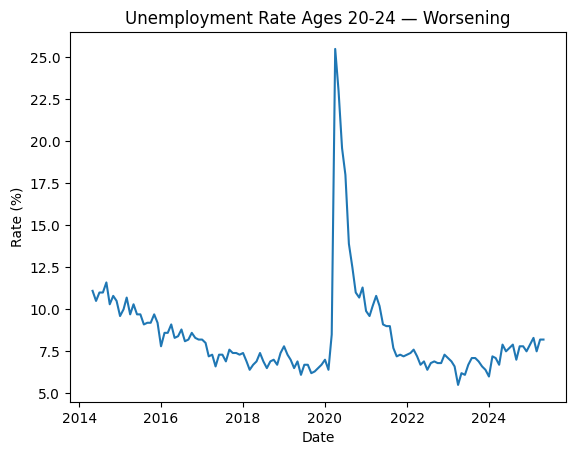

In [249]:
plt.plot(df['Date'], df['Unemployment Rate Ages 20-24'])
if df['Unemployment Rate Ages 20-24'].iloc[-1] > df['Unemployment Rate Ages 20-24'].iloc[-13]:
    label = "Worsening"
else:
    label = "Improving"
plt.title(f"Unemployment Rate Ages 20-24 — {label}")
plt.ylabel("Rate (%)")
plt.xlabel("Date")
plt.show()

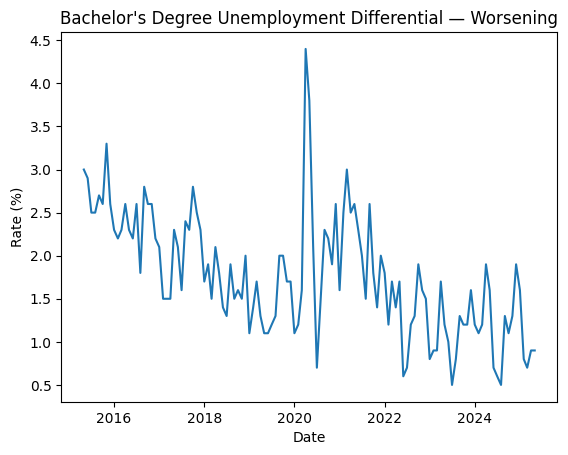

In [250]:
plt.plot(df_transformed['Date'], df_transformed['Bach. Degree Unemployment Differential'])
if df_transformed['Bach. Degree Unemployment Differential'].iloc[-1] < df_transformed['Bach. Degree Unemployment Differential'].iloc[-13]:
    label = "Worsening"
else:
    label = "Improving"
plt.title(f"Bachelor's Degree Unemployment Differential — {label}")
plt.ylabel("Rate (%)")
plt.xlabel("Date")
plt.show()

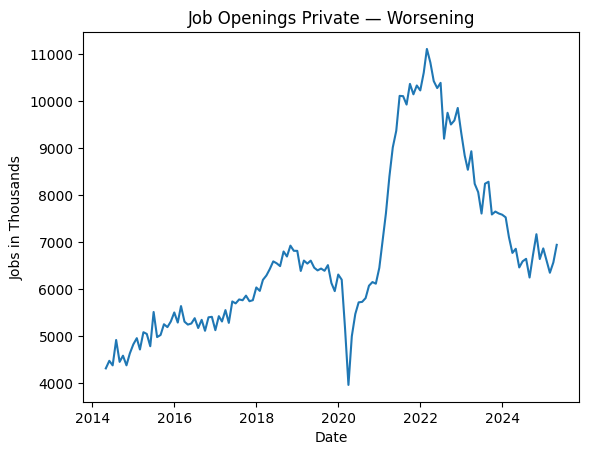

In [254]:
plt.plot(df['Date'], df['Job Openings Private'])
if df['Job Openings Private'].iloc[-1] > df['Job Openings Private'].iloc[-13]:
    label = "Worsening"
else:
    label = "Improving"
plt.title(f"Job Openings Private — {label}")
plt.ylabel("Jobs in Thousands")
plt.xlabel("Date")
plt.show()

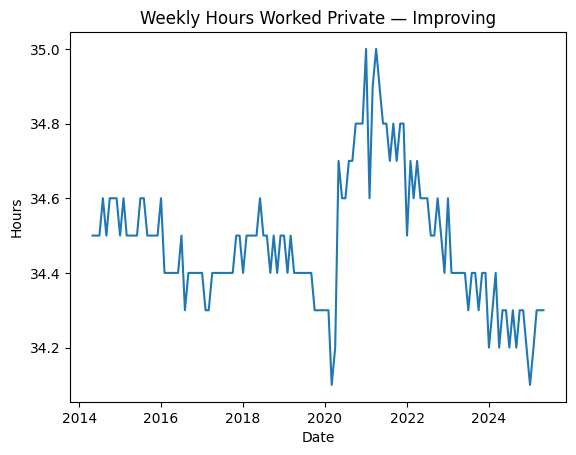

In [255]:
plt.plot(df['Date'], df['Weekly Hours Worked Private'])
if df['Weekly Hours Worked Private'].iloc[-1] > df['Weekly Hours Worked Private'].iloc[-13]:
    label = "Worsening"
else:
    label = "Improving"
plt.title(f"Weekly Hours Worked Private — {label}")
plt.ylabel("Hours")
plt.xlabel("Date")
plt.show()

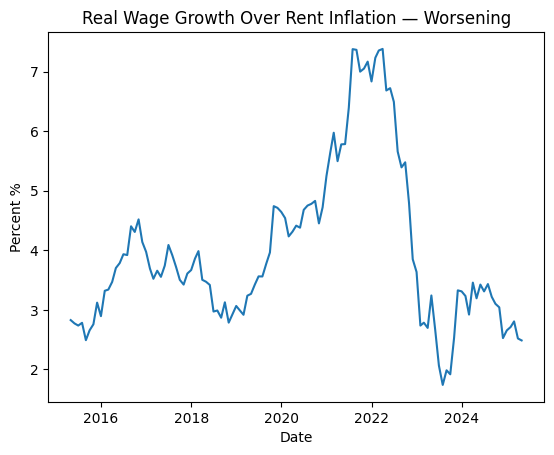

In [258]:
plt.plot(df_transformed['Date'], df_transformed['Real Wage Growth Over Rent Inflation'])
if df_transformed['Real Wage Growth Over Rent Inflation'].iloc[-1] < df_transformed['Real Wage Growth Over Rent Inflation'].iloc[-13]:
    label = "Worsening"
else:
    label = "Improving"
plt.title(f"Real Wage Growth Over Rent Inflation — {label}")
plt.ylabel("Percent %")
plt.xlabel("Date")
plt.show()

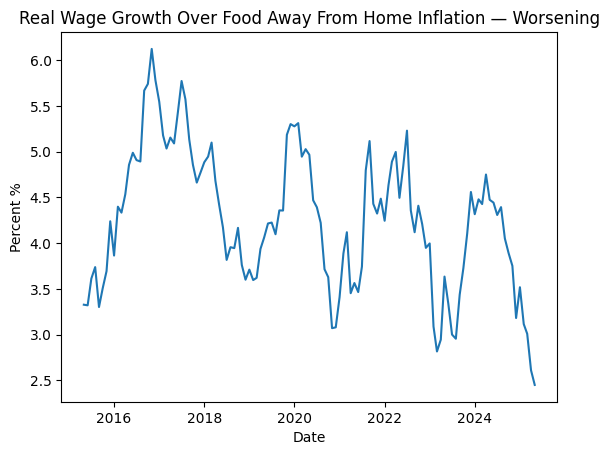

In [259]:
plt.plot(df_transformed['Date'], df_transformed['Real Wage Growth Over Food Away From Home Inflation'])
if df_transformed['Real Wage Growth Over Food Away From Home Inflation'].iloc[-1] < df_transformed['Real Wage Growth Over Food Away From Home Inflation'].iloc[-13]:
    label = "Worsening"
else:
    label = "Improving"
plt.title(f"Real Wage Growth Over Food Away From Home Inflation — {label}")
plt.ylabel("Percent %")
plt.xlabel("Date")
plt.show()